In [1]:
import torch
import cibsde.nn as nn
import matplotlib.pyplot as plt
device = torch.device('cuda:0')

In [2]:
d = 2
t = torch.tensor(1.,device=device)
D = torch.tensor(0.5,device=device)
N = 100
batch = 512
epoch = 10**4
lr = 1e-3

x0 = torch.tensor([0.75,0],device=device)

def data_gen(batch):
    r = torch.sqrt(torch.rand([batch,1],device=device)*3/4 + 1/4)
    theta = torch.rand([batch,1],device=device)*torch.pi*2
    x = torch.cat([torch.cos(theta),torch.sin(theta)],dim=1)*r
    return x

def pc(i,x):
    return ((x - x0).norm(dim=1,keepdim=True) < 0.25)*16/torch.pi

def refb(x):
    xnorm = x.norm(dim=1)
    out = (xnorm <= 0.5) | (xnorm >= 1)
    inner = xnorm < 0.75
    xb = x / xnorm.unsqueeze(1)
    xb[inner] = xb[inner] * 0.5
    n = x / xnorm.unsqueeze(1)
    n[inner] = -n[inner]
    return xb, n,out

def hitb(x):
    return torch.zeros(batch,device=device).bool()

def f(t,xt,p,grad_p):
    return torch.zeros([batch,1],device=device)

def mu(t,xt):
    return torch.zeros([batch,d],device=device)

def sigma(t,xt):
    return torch.eye(d,device=device).expand([batch,d,d]).clone()*torch.sqrt(2*D)

model = nn.BoundaryIBSDE(
    d = 2,
    t = t,
    f = f,
    mu = mu,
    sigma = sigma,
    pc = pc,
    data_gen = data_gen,
    N = N,
    refb = refb,
    hitb = hitb,
    param = False
).to(device)

In [3]:
train_params = {
    'epoch': epoch,
    'batch': batch,
    'lr': lr
}

loss_values = nn.train(
    model,
    train_params
)

10000/10000|##################################################|3972.65s  [Loss: 6.244358e-01] 
Training has been completed.


In [4]:
shape = [101,201]
r = torch.linspace(0.5,1,shape[0],device=device)
theta = torch.linspace(0,torch.pi*2,shape[1],device=device)
r, theta = torch.meshgrid(r,theta)
x = torch.stack([torch.cos(theta),torch.sin(theta)],dim=2)*r.unsqueeze(-1)
y = model.p(x.reshape([shape[0]*shape[1],2])).detach().cpu().reshape(shape)

d:\Anaconda3\envs\torch\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


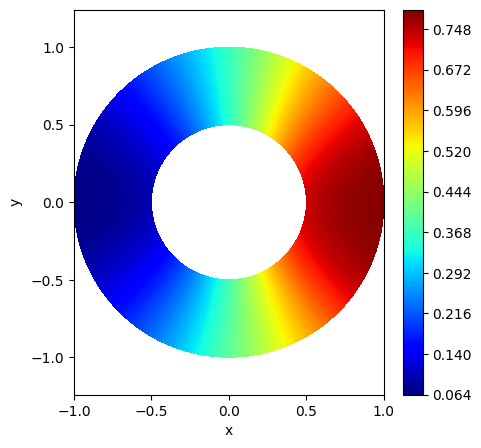

In [6]:
plt.figure(figsize=(5,5))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axis('equal')
plt.contourf(x[:,:,0].cpu(),x[:,:,1].cpu(),y,200,cmap='jet')
plt.colorbar()
plt.show()